# Scalar Field Theory Monte Carlo Simulations

Faris Sbahi

# Project 1

In this project, we will study a $d$ dimensional scalar field theory on the lattice.

Define the lattice action

$$
S^l_E = \sum_x \{ \frac{1}{2} \chi_x^2 - \frac{\kappa}{2} \sum_{\mu} \chi_x \chi_{x + \hat{\mu}} + g \chi_x^4 \}
$$

$$
\kappa^{-1} := 2d + \alpha \\
\alpha := (m_0a)^2
$$

where $m_0$ is the bare lattice mass term and $a$ is the lattice spacing.

First, fix $g=0$. We wish to compute 

$$
\sigma = \frac{1}{L^d}\sum_x \langle \chi^2_x \rangle
$$

By definition,

$$
\langle \phi(x) \phi(y)\rangle = \frac{1}{Z} \int [d \phi] e^{-S_E(\phi)} \phi(x) \phi(y)
$$

where 


$$
Z = \int [d\phi] e^{-S_E(\phi)}
$$

Hence,

$$
\langle \chi^2_x \rangle = \frac{1}{Z}\int [d \phi] e^{-S_E(\phi)} \chi^2_x
$$

and we can construct $S$ as a matrix-vector product in terms of $M$

$$
S_E^l = \frac{1}{2}\chi_{i}M_{ij}\chi_{j}\\
M_{ij} = - \kappa \sum_{\mu} (\delta_{i + \mu, j} + \delta_{i - \mu, j}) + \delta_{ij}
$$


> Note: it takes too long to build it up in $d=4$ so an alternative is recognize that $g=0$, $\kappa$ nonzero is an NN coupling and Fourier transform to momentum space. There the coupling will be eliminated so you should be able to do a couple of integrals.

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer as timer

from numba import njit

In [18]:
@njit
def m_ij(i, j, L, d, kappa, g):
    if i == j:
        return 1
    
    for axis in range(d):
        if ((i + L**axis) % (L ** d) == j) or ((i - L**axis) % (L ** d) == j):
            return -1 * kappa
        
    return 0

@njit
def M_inv(L, d, kappa, g):
    M = np.zeros((L ** d, L ** d))
    
    for i in range(L**d):
        for j in range(L ** d):
            M[i, j] = m_ij(i, j, L, d, kappa, g)
            
    return np.linalg.inv(M)

# 1. $L = 16, g = 0, \alpha = 0.25$

In [19]:
@njit
def compute_exact_observables(G, L, d):
    sigma = np.trace(G) / (L ** d)
    
    chi = np.sum(G) / (L ** d)
    
    
    F_mat = np.array(
            [ G[i,j] * np.cos(2 * np.pi * (
                (i % L) - (j % L)
                ) / L
                ) for i in range(L**d) for j in range(L**d)]
        )
    
    F = np.sum(F_mat) / (L**d)
    
    M_L = 2 * (np.sin(np.pi / L)) / (np.sqrt((chi / F) - 1)) # desire chi/F = 1.61
    
    return sigma, chi, F, M_L    

In [20]:
g = 0
L = 2 ** 4

alpha = 0.25

for d in [2, 3]:
    start = timer()
    
    print("d: ", d)
    
    kappa = 1 / ( 2 * d + alpha)
    
    G = M_inv(L, d, kappa, g)
    
    sigma, chi, F, M_L = compute_exact_observables(G, L, d)
    
    dt = timer() - start
    
    print("sigma: ", sigma, "chi: ", chi, "F: ", F, "M_L: ", M_L)
    print("time: ", dt)

d:  2
sigma:  1.6020690583803094 chi:  16.99999999999997 F:  10.565806785027261 M_L:  0.5000000000000324
time:  1.6339946639927803
d:  3
sigma:  1.319788680629584 chi:  25.000000000070056 F:  15.537951154259856 M_L:  0.4999999999900183
time:  7.825207175003015


# $L = 16, g = 0.1, \alpha = 0.25, \kappa = 0$

In [6]:
g = 0.1
L = 2 ** 4

alpha = 0.25

for d in range(2, 5):
    print("d: ", d)
    
    kappa = 1 / ( 2 * d + alpha)
    
    G = M_inv(L, d, kappa, g)
    
    sigma = np.trace(G) / (L ** d)
    
    chi = np.sum(G) / (L ** d)
    
    F = np.sum(
    [ G[i,j] * np.cos(2 * np.pi * (
        (i % L) - (j % L)
        ) / L
        ) for i in range(L**d) for j in range(L**d)]) / (L**d)
    
    M_L = 2 * (np.sin(np.pi / L)) / (np.sqrt((chi / F) - 1)) # desire chi/F = 1.61
    
    print("sigma: ", sigma, "chi: ", chi, "F: ", F, "M_L: ", M_L)

d:  2


TypeError: too many arguments: expected 3, got 4

$$
\langle \phi(x) \phi(y)\rangle =  \int [d \phi] P([\phi]) \phi(x) \phi(y)
$$

for 

$$
P([\phi]) = \frac{e^{-S_E^l(\phi)}}{Z}
$$

to simplify take configuration

$$
\zeta := [\phi]
$$

and

$$
W(\zeta) = e^{-S_E^l(\phi)} 
$$

so that

$$
P(\zeta) = \frac{W(\zeta)}{\sum_{\zeta} W(\zeta)}
$$

Now, write

$$
\chi_x \equiv \rho_x s_x
$$

with $s_x = sgn(\chi_x)$. And so

$$
S_E^l(x) = \sum_x \{ \frac{1}{2} \rho_x^2 - \frac{\kappa}{2} \sum_{\mu} \rho_x \rho_{x + \hat{\mu}}s_x s_{x + \hat{\mu}} + g \rho_x^4 \}
$$

For the spin update $\rho$ is fixed so that

$$
W(\zeta) = \exp(-\sum_{\mu} \rho_x \rho_{x + \hat{\mu}}s_x s_{x + \hat{\mu}})
$$

and so the spin update for $T$ has the following algorithm:

1. Keep two lists: sites_visited, sites_visited_flag

2. Initialize: pick site at random
    - add to sites_visited
    - mark as visited with flag
    
3. Go over all visited sites and look over all neighboring directions. Let the visted site have spin $s_1$ and its neighbor $s_2$:
    - if $s_1 \neq s_2$ do nothing
    - if $s_1 = s_2$ then with probability $1-\exp(-2 \kappa \rho_x \rho_y)$

4. Repeat for all site in sites_visited

5. When all sites of sites_visisted have been exhausted, then flip the signs of all on sites_visited_flag

Now, for the regular update let us define a constant (recalling that we update one site at a time)

$$
\alpha := \kappa \sum_{x, \hat{\mu}} (\chi_{x + \hat{\mu}} + \chi_{x - \hat{\mu}})
$$

and hence, up to a constant,

$$
W(\zeta) = \exp(-\frac{1}{2} (\chi_x - \alpha)^2 - g \chi_x^4)
$$



In [21]:
@njit
def get_neighbors(idx, L, d):
    n = np.array([(idx + direction * (L ** dim)) % (L ** d) for direction in [-1, 1] for dim in range(d)])
    return n

@njit # TODO - parallel
def spin_update(lattice_rad, lattice_signs, L, d, kappa):
    sites_visited = []
    sites_visited_flag = set()

    init = np.random.randint(0, high = L ** d - 1)

    sites_visited.append(init)
    sites_visited_flag.add(init)

    while (len(sites_visited) != 0 and len(sites_visited_flag) != L ** d):
        idx = sites_visited.pop()
        for nbr_idx in get_neighbors(idx, L, d):
            #print("checking spin for time dim: ", idx % L, nbr_idx % L)
            #print("sites visited: ", sites_visited_flag, lattice_signs[nbr_idx], lattice_signs[idx])
            #print(nbr_idx not in sites_visited_flag and lattice_signs[nbr_idx] == lattice_signs[idx])
            if nbr_idx not in sites_visited_flag and lattice_signs[nbr_idx] == lattice_signs[idx]:
                #print(nbr_idx)
                
                prob = 1 - np.exp(- 2 * kappa * lattice_rad[idx] * lattice_rad[nbr_idx])
                s = np.random.random()
                #print(s, prob)
                if s <= prob:
                    #print("added time dim: ", idx % L, nbr_idx % L)
                    sites_visited.append(nbr_idx)
                    sites_visited_flag.add(nbr_idx)

    return init, np.array(list(sites_visited_flag))

@njit
def update_spin_at_sites(lattice_signs, sites):
    lattice_signs[sites] = -1 * lattice_signs[sites]

@njit
def regular_update(lattice_rad, lattice_signs, g, L, d, kappa):
    for idx in range(L ** d):
        gauss = np.random.randn()
        
        nbrs = get_neighbors(idx, L, d)
        alpha = kappa * np.dot(lattice_rad[nbrs], lattice_signs[nbrs])
        
        new_chi = alpha + gauss
        
        s = np.random.uniform(b=1.0, a=0.0)
        prob = np.exp(-g * (new_chi ** 4 - lattice_rad[idx] ** 4))
        
        if g == 0 or s <= prob: 
            lattice_rad[idx] = np.abs(new_chi)
            lattice_signs[idx] = np.sign(new_chi)

In [22]:
@njit
def compute_sigma(lattice_rad, L, d):
    return np.sum(lattice_rad ** 2) / (L ** d)

@njit
def compute_chi(x, lattice_rad, L, d, sites):
    rho_x = lattice_rad[x]
    return np.sum(rho_x * lattice_rad[sites])

@njit
def compute_F(x, lattice_rad, L, d, sites):        
    rho_x = lattice_rad[x]
            
    return np.sum(
        np.array(
    [ rho_x * lattice_rad[idx] * np.cos(2 * np.pi * (
        (x % L) - (idx % L)
        ) / L
        ) for idx in sites]))
    

# 2. $L = 16, g = 0, \alpha = 0.25$

In [23]:
@njit
def run_monte_carlo(L, g, alpha, N, d, kappa):
    sigmas = []
    sigma = 0

    chis = []
    chi = 0

    Fs = []
    F = 0

    lattice_signs = np.ones(L ** d)
    lattice_rad = np.random.uniform(b=1.0, a=0.0, size=int(L**d))

    for i in range(N):
        x, sites = spin_update(lattice_rad, lattice_signs, L, d, kappa)

        chi_i = compute_chi(x, lattice_rad, L, d, sites)
        chi += chi_i / N
        chis.append(chi_i)

        F_i = compute_F(x, lattice_rad, L, d, sites)
        F += F_i / N
        Fs.append(F_i)

        update_spin_at_sites(lattice_signs, sites)
        regular_update(lattice_rad, lattice_signs, g, L, d, kappa)

        sigma_i = compute_sigma(lattice_rad, L, d)
        sigma += sigma_i / N
        sigmas.append(sigma_i)

    return sigma, chi, F, sigmas, chis, Fs
        

In [11]:
N = 10000
alpha = 0.25
L = 16
g = 0.

all_sigmas = []
all_chis = []
all_Fs = []

for d in [2, 3, 4]: #[2, 3, 4]:
    print("d: ", d)
    print("g: ", g)

    start = timer()

    kappa = 1 / ( 2 * d + alpha)

    sigma, chi, F, sigmas, chis, Fs = run_monte_carlo(L, g, alpha, N, d, kappa)

    M_L = 2 * (np.sin(np.pi / L)) / (np.sqrt((chi / F) - 1))

    print("Sigma: ", sigma)
    print("Chi: ", chi)
    print("F ", F)
    print("M(L): ", M_L)

    dt = timer() - start
    print("time: ", dt)

    all_sigmas.append(sigmas)
    all_chis.append(chis)
    all_Fs.append(Fs)

d:  2
g:  0.0
Sigma:  1.5984415596302293
Chi:  16.9758706747757
F  10.713789744858119
M(L):  0.5103615442114681
time:  3.025785347999772
d:  3
g:  0.0
Sigma:  1.3201007931136357
Chi:  25.795018225025938
F  15.577787527093415
M(L):  0.48178359667695225
time:  46.638673560002644
d:  4
g:  0.0
Sigma:  1.1994610085626465
Chi:  32.84545671097318
F  20.39686403515251
M(L):  0.49944456708655915
time:  772.0878117399989


# $L = 16, g = 0.1, \alpha = 0.25, \kappa = 0$

In [ ]:
N = 10000
alpha = 0.25
L = 16
g = 0.1

all_sigmas = []
all_chis = []
all_Fs = []

for d in [2, 3, 4]: #[2, 3, 4]:
    print("d: ", d)
    print("g: ", g)

    start = timer()

    kappa = 0.

    sigma, chi, F, sigmas, chis, Fs = run_monte_carlo(L, g, alpha, N, d, kappa)

    print("Sigma: ", sigma)
    print("Chi: ", chi)
    print("F ", F)

    dt = timer() - start
    print("time: ", dt)

    all_sigmas.append(sigmas)
    all_chis.append(chis)
    all_Fs.append(Fs)

d:  2
g:  0.1
Sigma:  0.6149778955031607
Chi:  0.6151468480344584
F  0.6151468480344584
time:  2.974809903993446
d:  3
g:  0.1
Sigma:  0.6156667143200424
Chi:  0.6240571595889625
F  0.6240571595889625
time:  46.149586159001046
d:  4
g:  0.1
Sigma:  0.6155380328555256
Chi:  0.6210792172801616
F  0.6210792172801616
time:  751.8440461270002


# 3. $L=8, g=0.1, \alpha = -1.5$

In [24]:
N = 10000
alpha = -1.5
L = 8
g = 0.1

all_sigmas = []
all_chis = []
all_Fs = []

for d in [2, 3, 4]: #[2, 3, 4]:
    print("d: ", d)
    print("g: ", g)

    start = timer()

    kappa = 1 / ( 2 * d + alpha)

    sigma, chi, F, sigmas, chis, Fs = run_monte_carlo(L, g, alpha, N, d, kappa)

    M_L = 2 * (np.sin(np.pi / L)) / (np.sqrt((chi / F) - 1))

    print("Sigma: ", sigma)
    print("Chi: ", chi)
    print("F ", F)
    print("M(L): ", M_L)

    dt = timer() - start
    print("time: ", dt)
    print("\n")

    all_sigmas.append(sigmas)
    all_chis.append(chis)
    all_Fs.append(Fs)

d:  2
g:  0.1
Sigma:  0.829531147869235
Chi:  6.033634433108163
F  2.454913761208728
M(L):  0.6339045593828405
time:  3.233703966005123


d:  3
g:  0.1
Sigma:  0.6854868282648279
Chi:  2.8405736382567524
F  2.0801998825819896
M(L):  1.2659269065066692
time:  6.282384076010203


d:  4
g:  0.1
Sigma:  0.6561583795432983
Chi:  2.376125610515098
F  1.991016683231391
M(L):  1.7402647070872304
time:  47.833176100000856




# Project 2

In the symmetric phase one can argue that

$$
\langle \phi(x) \phi(x') \rangle = \int d^dp \frac{Z}{p^2 + M^2_{phys}}(1+O(p^2)) e^{i p \cdot (x-x')}
$$

where $Z$ is the residue of the propagator (a constant).



In [66]:
N = 10000
alpha = -0.5
d = 2
g = 0.01

all_sigmas = []
all_chis = []
all_Fs = []

for L in [24, 32, 48]:
    print("d: ", d)
    print("g: ", g)
    print("L: ", L)
    print("alpha:", alpha)

    start = timer()

    kappa = 1 / ( 2 * d + alpha)

    sigma, chi, F, sigmas, chis, Fs = run_monte_carlo(L, g, alpha, N, d, kappa)

    M_L = 2 * (np.sin(np.pi / L)) / (np.sqrt((chi / F) - 1))

    print("Sigma: ", sigma)
    print("Chi: ", chi)
    print("F ", F)
    print("M(L): ", M_L)

    dt = timer() - start
    print("time: ", dt)
    print("\n")

    all_sigmas.append(sigmas)
    all_chis.append(chis)
    all_Fs.append(Fs)

d:  2
g:  0.01
L:  24
alpha: -0.5
Sigma:  1.652348985195478
Chi:  47.5039421795629
F  24.742523716507257
M(L):  0.2721761085087942
time:  6.533813570000348


d:  2
g:  0.01
L:  32
alpha: -0.5
Sigma:  1.6532572585624563
Chi:  45.91482670071023
F  30.55917605858576
M(L):  0.27654686032302606
time:  11.1737503559998


d:  2
g:  0.01
L:  48
alpha: -0.5
Sigma:  1.6489524336071149
Chi:  45.64571842678918
F  36.995400337252875
M(L):  0.2705118847296773
time:  23.61126716200306




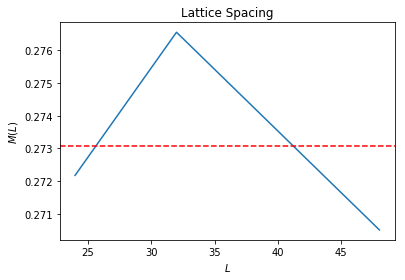

In [29]:
plt.figure()


M_Ls = [0.2721761085087942, 0.27654686032302606, 0.2705118847296773]
plt.plot([24, 32, 48], M_Ls)

plt.axhline(y=np.mean(M_Ls), color='r', linestyle='--')

plt.xlabel(r'$L$')
plt.ylabel(r'$M(L)$')
plt.title("Lattice Spacing")

plt.show()

## 3. Renormalization

In [8]:
N = 10000
d = 2
L = 48
g = 0.01

M_Ls = []
alphas = [-0.55, -0.56, -0.57, -0.58, -0.59, -0.60, -0.61]

for alpha in alphas:
    print("d: ", d)
    print("g: ", g)
    print("L: ", L)
    print("alpha: ", alpha)

    start = timer()

    kappa = 1 / ( 2 * d + alpha)

    sigma, chi, F, sigmas, chis, Fs = run_monte_carlo(L, g, alpha, N, d, kappa)

    M_L = 2 * (np.sin(np.pi / L)) / (np.sqrt((chi / F) - 1))

    print("Sigma: ", sigma)
    print("Chi: ", chi)
    print("F ", F)
    print("M(L): ", M_L)

    dt = timer() - start
    print("time: ", dt)
    print("\n")

    M_Ls.append(M_L)
    
print("M(L)s: ", M_Ls)

d:  2
g:  0.01
L:  48
alpha:  -0.55
Sigma:  1.780878488497354
Chi:  81.91013939866458
F  58.72651951644531
M(L):  0.20818768263690218
time:  24.83078293300059


d:  2
g:  0.01
L:  48
alpha:  -0.56
Sigma:  1.8092289568930504
Chi:  92.34045696128958
F  63.33327830824958
M(L):  0.19328215672079688
time:  24.713867095997557


d:  2
g:  0.01
L:  48
alpha:  -0.57
Sigma:  1.8498794064874475
Chi:  116.2145131161416
F  72.41937620666407
M(L):  0.1682065754690425
time:  24.892001247004373


d:  2
g:  0.01
L:  48
alpha:  -0.58
Sigma:  1.8943220133180667
Chi:  138.68010105041293
F  78.49382350654061
M(L):  0.149381743476691
time:  25.36099804499827


d:  2
g:  0.01
L:  48
alpha:  -0.59
Sigma:  1.933380097572247
Chi:  172.91478084779146
F  88.01759302613073
M(L):  0.13318846541641502
time:  25.274512531002983


d:  2
g:  0.01
L:  48
alpha:  -0.6
Sigma:  1.9918471089608683
Chi:  232.62750961534255
F  99.71879663820391
M(L):  0.11330271368114678
time:  25.288053690994275


d:  2
g:  0.01
L:  48
alpha

f_0:  1.7239615497775271 alpha_c:  -0.6686205830192596


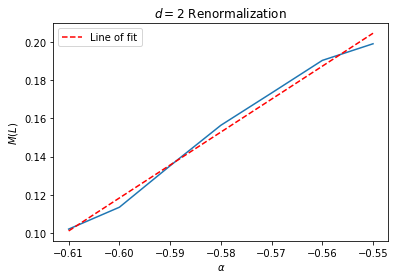

In [33]:
alphas = [-0.55, -0.56, -0.57, -0.58, -0.59, -0.60, -0.61]
M_Ls = [0.20818768263690218, 0.19328215672079688, 0.1682065754690425, 0.149381743476691, 0.13318846541641502, 0.11330271368114678, 0.10499868450940378]
z = np.polyfit(alphas, M_Ls, 1)

f_0 = z[0]
alpha_c = -1 * z[1] / z[0]
print("f_0: ", f_0, "alpha_c: ", alpha_c)

grid_x = np.linspace(np.min(alphas), np.max(alphas), 1000)
grid_y = f_0 * (grid_x - alpha_c)

plt.figure()

plt.plot(
    alphas, 
    M_Ls
        )

plt.title(r'$d=2$ Renormalization')
plt.ylabel(r'$M(L)$')
plt.xlabel(r'$\alpha$')

plt.plot(grid_x, grid_y, color='r', linestyle='--', label="Line of fit")
plt.legend()
plt.show()

In [25]:
N = 10000
d = 3
L = 48
g = 0.01

M_Ls = []
alphas = [-0.68, -0.69, -0.70, -0.71, -0.72]

for alpha in alphas:
    print("d: ", d)
    print("g: ", g)
    print("L: ", L)
    print("alpha: ", alpha)

    start = timer()

    kappa = 1 / ( 2 * d + alpha)

    sigma, chi, F, sigmas, chis, Fs = run_monte_carlo(L, g, alpha, N, d, kappa)

    M_L = 2 * (np.sin(np.pi / L)) / (np.sqrt((chi / F) - 1))

    print("Sigma: ", sigma)
    print("Chi: ", chi)
    print("F ", F)
    print("M(L): ", M_L)

    dt = timer() - start
    print("time: ", dt)
    print("\n")

    M_Ls.append(M_L)
    
print("M(L)s: ", M_Ls)

d:  3
g:  0.01
L:  48
alpha:  -0.68
Sigma:  1.2543432180617662
Chi:  141.45050542683043
F  88.52194818056502
M(L):  0.1691644017051322
time:  1206.5283406189992


d:  3
g:  0.01
L:  48
alpha:  -0.69
Sigma:  1.2612191442189458
Chi:  172.995149871929
F  109.02072554453531
M(L):  0.17075752999560584
time:  1204.4179673640028


d:  3
g:  0.01
L:  48
alpha:  -0.7
Sigma:  1.269941861610701
Chi:  269.05785004206996
F  129.12833916503578
M(L):  0.12565641006370512
time:  1204.305212819003


d:  3
g:  0.01
L:  48
alpha:  -0.71
Sigma:  1.2803816064072768
Chi:  396.5244389612164
F  164.10731771779544
M(L):  0.10991537303445088
time:  1204.9614940019965


d:  3
g:  0.01
L:  48
alpha:  -0.72
Sigma:  1.2904615808119766
Chi:  612.0474254421713
F  196.80807020854493
M(L):  0.09005352575124376
time:  1206.6014635800093


M(L)s:  [0.1691644017051322, 0.17075752999560584, 0.12565641006370512, 0.10991537303445088, 0.09005352575124376]


[0.05957132 0.06046433 0.03715939 0.03004696 0.02189782]
f_0:  1.0359364396505866 alpha_c:  -0.7395482551631007


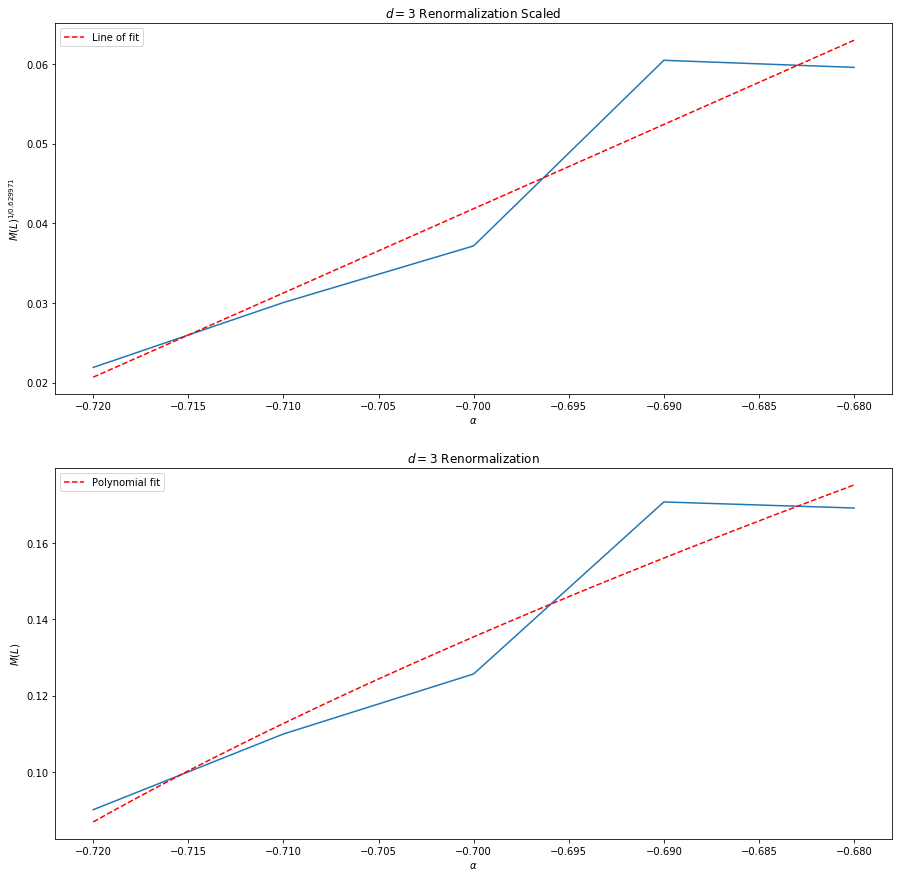

In [28]:
alphas = [-0.68, -0.69, -0.70, -0.71, -0.72]
M_Ls = [0.1691644017051322, 0.17075752999560584, 0.12565641006370512, 0.10991537303445088, 0.09005352575124376]

M_Ls_scaled = np.power(M_Ls, 1. / 0.629971) 

print(M_Ls_scaled)

z = np.polyfit(alphas, M_Ls_scaled, 1)
f_0 = np.power(z[0], 0.629971) # (-x)^d !
alpha_c = -1 * z[1] / z[0]
print("f_0: ", f_0, "alpha_c: ", alpha_c)

grid_x = np.linspace(np.min(alphas), np.max(alphas), 1000)
grid_y = grid_x * z[0] + z[1]

plt.figure(figsize=(15, 15))

plt.subplot(2, 1, 1)

plt.plot(
    alphas, 
    M_Ls_scaled
        )

plt.title(r'$d=3$ Renormalization Scaled')
plt.ylabel(r'$M(L)^{1/ 0.629971}$')
plt.xlabel(r'$\alpha$')

plt.plot(grid_x, grid_y, color='r', linestyle='--', label="Line of fit")
plt.legend()

plt.subplot(2, 1, 2)

plt.plot(
    alphas, 
    M_Ls
        )

plt.title(r'$d=3$ Renormalization')
plt.ylabel(r'$M(L)$')
plt.xlabel(r'$\alpha$')

grid_x = np.linspace(np.min(alphas), np.max(alphas), 1000)
grid_y = f_0 * np.power((grid_x - alpha_c), 0.629971)

plt.plot(grid_x, grid_y, color='r', linestyle='--', label="Polynomial fit")
plt.legend()

plt.show()

In [5]:
N = 10000
d = 4
L = 12
g = 0.01

M_Ls = []
alphas = [-0.55, -0.6, -0.65, -0.7, -0.75]

for alpha in alphas:
    print("d: ", d)
    print("g: ", g)
    print("L: ", L)
    print("alpha: ", alpha)

    start = timer()

    kappa = 1 / ( 2 * d + alpha)

    sigma, chi, F, sigmas, chis, Fs = run_monte_carlo(L, g, alpha, N, d, kappa)

    M_L = 2 * (np.sin(np.pi / L)) / (np.sqrt((chi / F) - 1))

    print("Sigma: ", sigma)
    print("Chi: ", chi)
    print("F ", F)
    print("M(L): ", M_L)

    dt = timer() - start
    print("time: ", dt)
    print("\n")

    M_Ls.append(M_L)

print("M(L)s: ", M_Ls)

d:  4
g:  0.01
L:  12
alpha:  -0.55
Sigma:  1.0640235145702879
Chi:  22.832920573209716
F  11.905996398268043
M(L):  0.5403313113544943
time:  242.06524213000012


d:  4
g:  0.01
L:  12
alpha:  -0.6
Sigma:  1.0684387273982054
Chi:  29.56408214443639
F  13.764259604381063
M(L):  0.48314395406613714
time:  238.41278849099763


d:  4
g:  0.01
L:  12
alpha:  -0.65
Sigma:  1.073237583715378
Chi:  33.97494194837796
F  15.442676056167356
M(L):  0.4725233187491617
time:  238.18154719900122


d:  4
g:  0.01
L:  12
alpha:  -0.7
Sigma:  1.0787280222253828
Chi:  41.4486802683896
F  16.758550421651606
M(L):  0.42646438142486853
time:  238.46829875200274


d:  4
g:  0.01
L:  12
alpha:  -0.75
Sigma:  1.0842795477897096
Chi:  59.75422159898597
F  18.688248187247957
M(L):  0.34919616216514876
time:  238.08217136099847


M(L)s:  [0.5403313113544943, 0.48314395406613714, 0.4725233187491617, 0.42646438142486853, 0.34919616216514876]


f_0:  0.8849815189538857 alpha_c:  -0.918765189945667


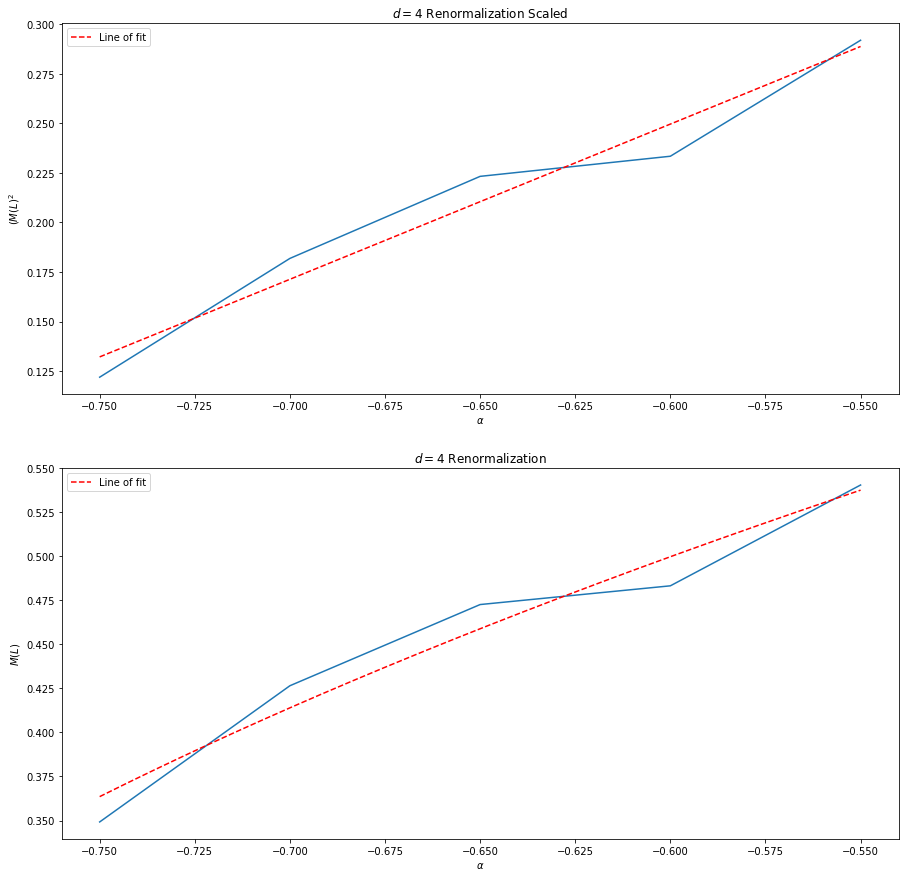

In [30]:
alphas = [-0.55, -0.6, -0.65, -0.7, -0.75]
M_Ls = [0.5403313113544943, 0.48314395406613714, 0.4725233187491617, 0.42646438142486853, 0.34919616216514876]

M_Ls_scaled = np.power(M_Ls, 1. / 0.5)

z = np.polyfit(alphas, M_Ls_scaled, 1)
f_0 = np.power(z[0], 0.5)
alpha_c = -1 * z[1] / z[0]
print("f_0: ", f_0, "alpha_c: ", alpha_c)

grid_x = np.linspace(np.min(alphas), np.max(alphas), 1000)
grid_y = grid_x * z[0] + z[1]

plt.figure(figsize=(15, 15))

plt.subplot(2, 1, 1)

plt.plot(
    alphas, 
    M_Ls_scaled
        )

plt.title(r'$d=4$ Renormalization Scaled')
plt.ylabel(r'$(M(L)^{2}$')
plt.xlabel(r'$\alpha$')

plt.plot(grid_x, grid_y, color='r', linestyle='--', label="Line of fit")
plt.legend()

plt.subplot(2, 1, 2)

plt.plot(
    alphas, 
    M_Ls
        )

plt.title(r'$d=4$ Renormalization')
plt.ylabel(r'$M(L)$')
plt.xlabel(r'$\alpha$')

grid_x = np.linspace(np.min(alphas), np.max(alphas), 1000)
grid_y = f_0 * np.power((grid_x - alpha_c), 0.5)

plt.plot(grid_x, grid_y, color='r', linestyle='--', label="Polynomial fit")
plt.legend()

plt.show()

# 4. Spontaneous Symmetry Breaking

In [9]:
N = 10000
d = 3
g = 0.01
alpha = -0.7

all_chis = []

for L in [16, 24, 32, 48]:
    print("d: ", d)
    print("g: ", g)
    print("L: ", L)
    print("alpha: ", alpha)

    start = timer()

    kappa = 1 / ( 2 * d + alpha)

    sigma, chi, F, sigmas, chis, Fs = run_monte_carlo(L, g, alpha, N, d, kappa)

    print("Sigma: ", sigma)
    print("Chi: ", chi)
    print("F ", F)

    dt = timer() - start
    print("time: ", dt)
    print("\n")

    all_chis.append(chis)

d:  3
g:  0.01
L:  16
alpha:  -0.7
Sigma:  1.282123810991686
Chi:  190.307250706889
F  29.956379249682083
time:  46.88516662299662


d:  3
g:  0.01
L:  24
alpha:  -0.7
Sigma:  1.272171368440082
Chi:  221.7967841030096
F  60.61859050026176
time:  153.90641149300063


d:  3
g:  0.01
L:  32
alpha:  -0.7
Sigma:  1.270669169808099
Chi:  270.3295101568825
F  87.89104156883843
time:  379.4472025189971


d:  3
g:  0.01
L:  48
alpha:  -0.7
Sigma:  1.270159603070715
Chi:  248.8529834959514
F  130.53817410187892
time:  1226.6781890380007




In [10]:
N = 10000
d = 3
g = 0.01
alpha = -0.8

all_chis = []

for L in [16, 24, 32, 48]:
    print("d: ", d)
    print("g: ", g)
    print("L: ", L)
    print("alpha: ", alpha)

    start = timer()

    kappa = 1 / ( 2 * d + alpha)

    sigma, chi, F, sigmas, chis, Fs = run_monte_carlo(L, g, alpha, N, d, kappa)

    print("Sigma: ", sigma)
    print("Chi: ", chi)
    print("F ", F)

    dt = timer() - start
    print("time: ", dt)
    print("\n")

    all_chis.append(chis)

d:  3
g:  0.01
L:  16
alpha:  -0.8
Sigma:  1.8792420060144404
Chi:  3092.2305024758803
F  19.364456608035493
time:  62.80782864399953


d:  3
g:  0.01
L:  24
alpha:  -0.8
Sigma:  1.885522268148324
Chi:  10599.547630350364
F  14.744924929683135
time:  205.16950135299703


d:  3
g:  0.01
L:  32
alpha:  -0.8
Sigma:  1.8838727378037352
Chi:  25127.322233589934
F  20.790088408907586
time:  489.7548197069991


d:  3
g:  0.01
L:  48
alpha:  -0.8
Sigma:  1.8833064272194113
Chi:  83722.27346049134
F  56.032326256989705
time:  1668.5827139359972




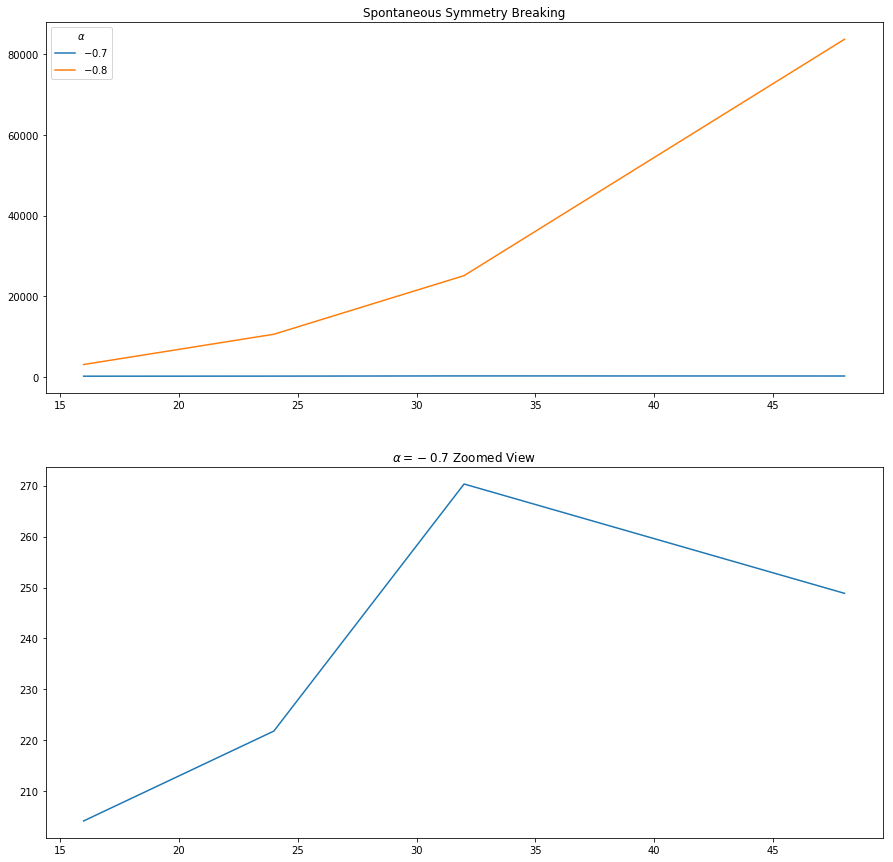

In [27]:
figsize = (20, 20)
plt.figure(figsize = (15, 15))

plt.xlabel("L")
plt.ylabel("Chi")

Ls = [16, 24, 32, 48]
chi1s = [204.14253149125554, 221.7967841030096, 270.3295101568825, 248.8529834959514]
chi2s = [3092.2305024758803, 10599.547630350364, 25127.322233589934, 83722.27346049134]

plt.subplot(2, 1, 1)

plt.title("Spontaneous Symmetry Breaking")

plt.plot(
    Ls, 
    chi1s,
    label=r'$-0.7$'
        )

plt.plot(
    Ls, 
    chi2s,
    label=r'$-0.8$'
        )

plt.legend(title=r'$\alpha$')

plt.subplot(2, 1, 2)
plt.title(r'$\alpha=-0.7$ Zoomed View')
plt.plot(
    Ls, 
    chi1s
)

plt.show()